#Stability map with MEGNO and WHFast
In this tutorial, we'll create a stability map of a two planet system using the chaos indicator MEGNO (Mean Exponential Growth of Nearby Orbits) and the symplectic integrator WHFast (Rein and Tamayo 2015).

We will integrate a two planet system with massive planets. We vary two orbital parameters, the semi-major axis $a$ and the eccentricity $e$. Let us first define a function that runs one simulation for a given set of initial conditions $(a, e)$.

In [1]:
def simulation(par):
    a, e = par # unpack parameters
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.integrator_whfast_safe_mode = 0
    sim.dt = 5.
    sim.add(m=1.) # Star
    sim.add(m=0.000954, a=5.204, anom=0.600, omega=0.257, e=0.048)
    sim.add(m=0.000285, a=a, anom=0.871, omega=1.616, e=e)
    sim.move_to_com()
    
    sim.init_megno(1e-16)
    sim.exit_max_distance = 20.
    try:
        sim.integrate(5e2*2.*np.pi) # integrator for 500 years
        megno = sim.calculate_megno() 
        return megno
    except rebound.Escape:
        return 10. # At least one particle got ejected, returning large MEGNO.

Let's try this out and run one simulation

In [2]:
import rebound
import numpy as np
simulation((7,0.1))

1.9997934339961634

The return value is the MEGNO. It is about 2, thus the system is regular for these initial conditions. Let's run a whole array of simulations.

In [3]:
Ngrid = 80
par_a = np.linspace(7.,10.,Ngrid)
par_e = np.linspace(0.,0.5,Ngrid)
parameters = []
for e in par_e:
    for a in par_a:
        parameters.append((a,e))
from rebound.interruptible_pool import InterruptiblePool
pool = InterruptiblePool()
results = pool.map(simulation,parameters)

On my laptop (dual core CPU), this takes only 3 seconds!

Let's plot it!

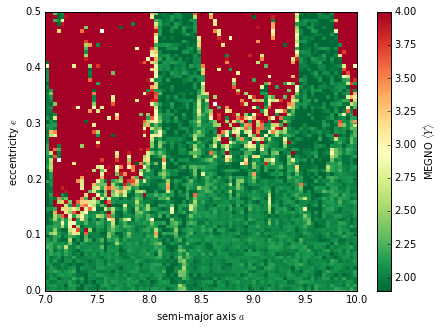

In [4]:
results2d = np.array(results).reshape(Ngrid,Ngrid)
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(par_a),max(par_a),min(par_e),max(par_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")
im = ax.imshow(results2d, interpolation="none", vmin=1.9, vmax=4, cmap="RdYlGn_r", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO $\\langle Y \\rangle$")